In [ ]:
#| hide

import os

In [ ]:
#| hide
# DONT RUN THIS CELL IN JUPYTER

os.chdir('../')

assert all([dir in os.listdir() for dir in ['data','configs']])
assert len(os.listdir('data/3_tfds_dataset')) == 3

# Exploratory Analysis
> Let's Explore the data

In [ ]:
#| hide
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import keras_cv


AUTOTUNE = tf.data.AUTOTUNE

import cv2
import os
import shutil
import numpy as np

from rocks_classifier.data.utils import *

%matplotlib inline 

# Exploring data

In [ ]:
#| hide
def check_corrupted(filepath):
    # only works with jpg, does not works with png
    fobj = None
    try:
        fobj = open(filepath, "rb")
        is_JFIF = b"JFIF" in fobj.peek(10)
        
    except:
        return True
    finally:
        if fobj:
            fobj.close()
    if not is_JFIF:
        return True
    return False


In [ ]:
#| hide

from typing import List

def get_dims(file: str) -> List[tuple]:
    """Return dimenstions for an RBG image.

    Parameters
    ----------
    file : str
        file path for image

    Returns
    -------
    Optional[tuple, None]
        returns a tuple of heights and width of image or None
    """
    im = cv2.imread(file)
    if im is not None:
        arr = np.array(im)
        h, w = arr.shape[0], arr.shape[1]
        return h, w
    elif im is None:
        return None

In [ ]:
#|code-fold: <show|true>
#|code-summary: Show code

df = get_df("data/2_processed")
df['dimensions'] = df['file_path'].apply(lambda x: get_dims(x))
df['image_width'] = df['dimensions'].apply(lambda x: x[0] if x is not None else None)
df['image_height'] = df['dimensions'].apply(lambda x: x[1] if x is not None else None)
df['pixels'] = df['image_width'] * df['image_height']
df['corrupt_status'] = df['file_path'].apply(lambda x: check_corrupted(x))
df.head(5)

file_name      class  \
0            dataset1_Limestone_147_23.jpg  Limestone   
1  dataset2_Limestone_418_Limestone521.jpg  Limestone   
2            dataset1_Limestone_315_78.jpg  Limestone   
3           dataset1_Limestone_078_168.jpg  Limestone   
4            dataset1_Limestone_305_69.jpg  Limestone   

                                           file_path file_type  dimensions  \
0  data/2_processed/Limestone/dataset1_Limestone_...      .jpg  (285, 380)   
1  data/2_processed/Limestone/dataset2_Limestone_...      .jpg  (225, 225)   
2  data/2_processed/Limestone/dataset1_Limestone_...      .jpg  (408, 612)   
3  data/2_processed/Limestone/dataset1_Limestone_...      .jpg  (408, 612)   
4  data/2_processed/Limestone/dataset1_Limestone_...      .jpg  (408, 612)   

   image_width  image_height    pixels  corrupt_status  
0        285.0         380.0  108300.0           False  
1        225.0         225.0   50625.0           False  
2        408.0         612.0  249696.0           False  
3        408.0         612.0  249696.0           False  
4        408.0         612.0  249696.0           False

## File types

In [ ]:
#|code-fold: <show|true>
df['file_name'].apply(lambda x: x.split('.')[-1]).value_counts()

jpg     1797
jpeg      23
png        8
JPEG       2
Name: file_name, dtype: int64

## Corrupt file counts

In [ ]:
#|code-fold: <show|true>
df.corrupt_status.value_counts()

False    1753
True       77
Name: corrupt_status, dtype: int64

Corrupted file list

In [ ]:
#|code-fold: <show|true>
df[df['corrupt_status']==True].head(5)

file_name      class  \
8    dataset1_Limestone_225_30.jpg  Limestone   
10  dataset1_Limestone_265_336.jpg  Limestone   
21  dataset1_Limestone_257_329.jpg  Limestone   
28   dataset1_Limestone_258_33.jpg  Limestone   
31  dataset1_Limestone_198_276.jpg  Limestone   

                                            file_path file_type    dimensions  \
8   data/2_processed/Limestone/dataset1_Limestone_...      .jpg    (450, 900)   
10  data/2_processed/Limestone/dataset1_Limestone_...      .jpg    (600, 600)   
21  data/2_processed/Limestone/dataset1_Limestone_...      .jpg  (1182, 1587)   
28  data/2_processed/Limestone/dataset1_Limestone_...      .jpg    (533, 800)   
31  data/2_processed/Limestone/dataset1_Limestone_...      .jpg    (533, 800)   

    image_width  image_height     pixels  corrupt_status  
8         450.0         900.0   405000.0            True  
10        600.0         600.0   360000.0            True  
21       1182.0        1587.0  1875834.0            True  
28        533.0         800.0   426400.0            True  
31        533.0         800.0   426400.0            True

In [ ]:
#| hide
df.describe()

image_width  image_height        pixels
count  1830.000000   1830.000000  1.830000e+03
mean    348.206011    463.434973  2.958651e+05
std     380.068514    397.609501  1.456111e+06
min      58.000000     77.000000  4.466000e+03
25%     194.000000    259.000000  5.035800e+04
50%     252.000000    311.500000  6.552000e+04
75%     408.000000    612.000000  2.496960e+05
max    6720.000000   5472.000000  3.010560e+07

In [ ]:
#| hide
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1832 entries, 0 to 1831
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       1832 non-null   object 
 1   class           1832 non-null   object 
 2   file_path       1832 non-null   object 
 3   file_type       1832 non-null   object 
 4   dimensions      1830 non-null   object 
 5   image_width     1830 non-null   float64
 6   image_height    1830 non-null   float64
 7   pixels          1830 non-null   float64
 8   corrupt_status  1832 non-null   bool   
dtypes: bool(1), float64(3), object(5)
memory usage: 116.4+ KB


In [ ]:
#| hide
df['image_width'].value_counts()

408.0    220
252.0    175
194.0    132
183.0    122
225.0     91
        ... 
595.0      1
467.0      1
564.0      1
494.0      1
166.0      1
Name: image_width, Length: 333, dtype: int64

<matplotlib.axes._subplots.AxesSubplot>

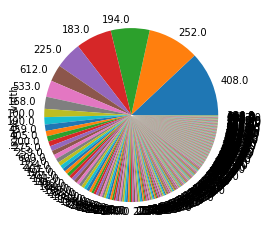

In [ ]:
#| hide
df['image_width'].value_counts().plot(kind='pie')

In [ ]:
#| hide
width_vc_bin = df.image_width.value_counts(bins = [i for i in range(1, 500, 20)])
width_vc_bin.values

array([440, 292, 223, 132, 129,  90,  38,  33,  28,  25,  23,  21,  19,
        16,  11,   9,   7,   6,   6,   1,   1,   0,   0,   0])

In [ ]:
#| hide
import seaborn as sns
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x=width_vc_bin.index, y=width_vc_bin.values)
plt.xlabel('image widths')
plt.ylabel('counts')
plt.show()

In [ ]:
#| hide
# sorted(list(df['image_width'].value_counts().index))
# sorted(list(df['image_height'].value_counts().index))

In [ ]:
#| hide
df['image_height'].value_counts()

612.0     398
259.0     125
275.0     111
800.0      92
225.0      91
         ... 
739.0       1
1400.0      1
560.0       1
616.0       1
365.0       1
Name: image_height, Length: 296, dtype: int64

In [ ]:
#| hide
min(df['class'].value_counts())

95

### Class Counts

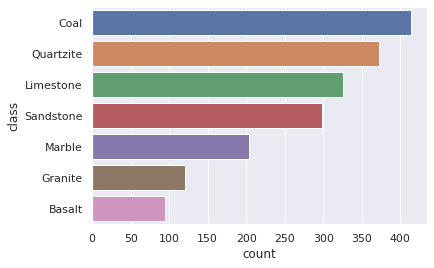

In [ ]:
#|code-fold: <show|true>
#| fig-cap: "Count of rock types."

import seaborn as sns
import pandas as pd

class_names = df['class'].value_counts().keys()
counts = df['class'].value_counts().values

count_df = pd.DataFrame(list(zip(class_names, counts)), columns=['class', 'count'])

sns.set_theme(style="darkgrid")
ax = sns.barplot(y='class', x='count', data=count_df)

## Image size analysis

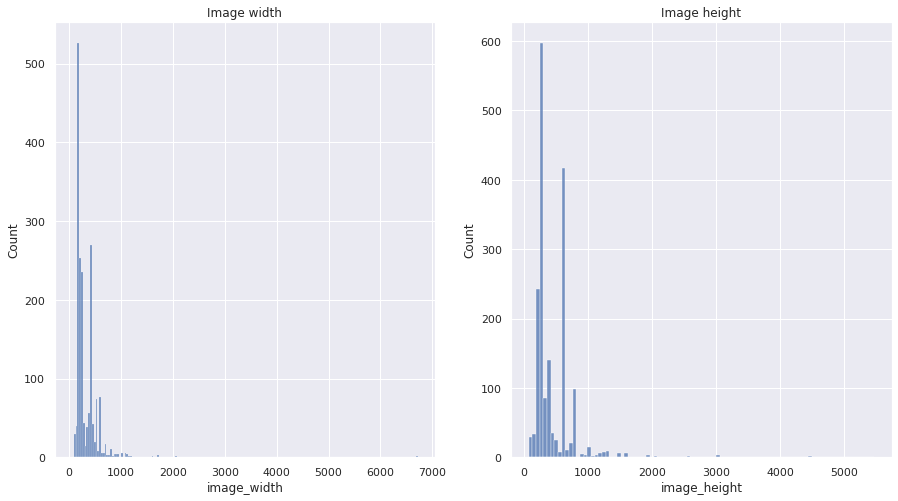

In [ ]:
#|code-fold: <show|true>

width_list = df.image_width
height_list = df.image_height
average_width = sum(width_list)/len(width_list)
average_height = sum(height_list)/len(height_list)

# print('average width: {} and height: {}'.format(average_width, average_height))

fig, ax =plt.subplots(1,2, figsize=(15, 8))

sns.histplot(width_list, ax=ax[0])
ax[0].set_title('Image width');
sns.histplot(height_list, ax=ax[1])
ax[1].set_title('Image height');

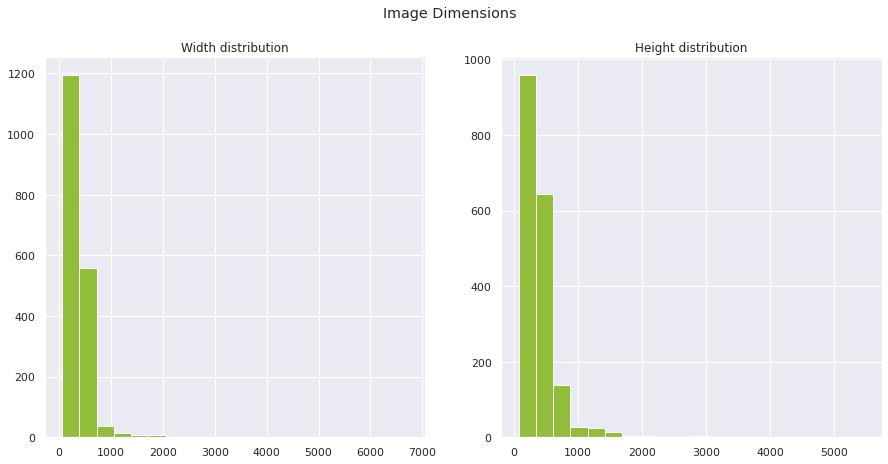

In [ ]:
#|code-fold: <show|true>
#| fig-cap: "Width and Height distribution."

# plot histograms to show the distribution of width and height values
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[0].hist(df.image_width.values, bins=20, color = '#91bd3a')
axs[0].set_title('Width distribution')
# axs[0].set_xlim(1000, 3000)

axs[1].hist(df.image_height.values, bins=20, color = '#91bd3a')
axs[1].set_title('Height distribution')
# axs[1].set_xlim(1000, 3000)

plt.suptitle('Image Dimensions')
plt.show()

## Sample counts

In [ ]:
#| hide

import omegaconf
path = 'configs/config.yaml'
cfg = omegaconf.OmegaConf.load(path)

In [ ]:
#|echo: false
print(f"Sampling type:- {cfg.sampling}.")

Sampling type:- None.


### Training set counts

In [ ]:
#|code-fold: <show|true>
get_df("data/3_tfds_dataset/train")['class'].value_counts()

Coal         289
Quartzite    261
Limestone    228
Sandstone    209
Marble       142
Granite       84
Basalt        66
Name: class, dtype: int64

### Validation set counts

In [ ]:
#|code-fold: <show|true>
get_df("data/3_tfds_dataset/val")['class'].value_counts()

Coal         62
Quartzite    55
Limestone    48
Sandstone    44
Marble       30
Granite      18
Basalt       14
Name: class, dtype: int64

### Test set counts

In [ ]:
#|code-fold: <show|true>
get_df("data/3_tfds_dataset/test")['class'].value_counts()

Coal         63
Quartzite    57
Limestone    50
Sandstone    46
Marble       32
Granite      19
Basalt       15
Name: class, dtype: int64

# Data Augmentation

In [ ]:
#| hide

# https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder
builder = tfds.ImageFolder('data/3_tfds_dataset')
print(builder.info)  # num examples, labels... are automatically calculated
data = builder.as_dataset(split=None, as_supervised=True)

num_classes = builder.info.features['label'].num_classes;

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='data/3_tfds_dataset',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=7),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=282, num_shards=1>,
        'train': <SplitInfo num_examples=1279, num_shards=1>,
        'val': <SplitInfo num_examples=271, num_shards=1>,
    },
    citation="""""",
)


## Sample Images

In [ ]:
#|code-fold: <show|true>
ds = builder.as_dataset(split='train', shuffle_files=True)
# tfds.show_examples(ds, builder.info)

In [ ]:
#| hide
# # https://stackoverflow.com/a/37343690/9292995
# # https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/

IMAGE_SIZE = (224, 224)


def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, 7)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset # .shuffle(10 * 8)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(8)
        )
    elif split == "val" or split == "test":
        return (
            dataset.map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(8)
        )


def load_dataset(split="train"):
    dataset = data[split]
    return prepare_dataset(dataset, split)


In [ ]:
#| hide
def visualize_dataset(dataset, title):
    plt.figure(figsize=(12, 12)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Samples before Augmentation

In [ ]:
#|code-fold: <show|true>
train_dataset = load_dataset()
visualize_dataset(train_dataset, title="Before Augmentation");

### Samples after RandAugment

In [ ]:
#| hide
def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)

cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

In [ ]:
#|code-fold: <show|true>
train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After RandAugment")

### Samples after cutmix and mixup augmentation

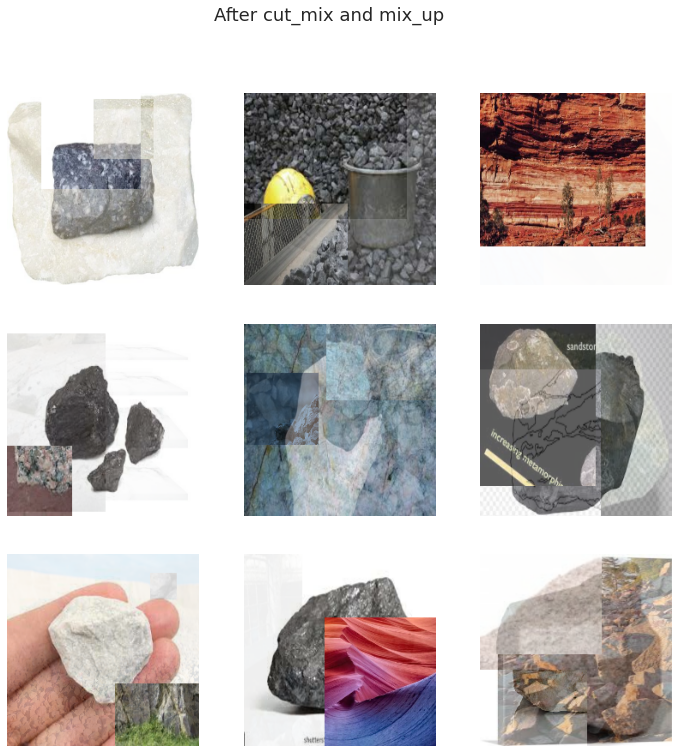

In [ ]:
#|code-fold: <show|true>
train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After cut_mix and mix_up")

# EDA using FastAI

In [ ]:
#| hide

from fastai.vision.all import *

In [ ]:
#| hide

def get_results(learn):
    print(f'\nSample Results:')
    learn.show_results()
    plt.show()

    interp = Interpretation.from_learner(learn)
    print(f'\nTop losses:-')
    interp.plot_top_losses(25, figsize=(20,20))
    loss_df = pd.DataFrame(interp.top_losses(items=True))
    plt.show()

    interp = ClassificationInterpretation.from_learner(learn)
    losses,idxs = interp.top_losses()
    len(dls.valid_ds)==len(losses)==len(idxs)

    print(f'\nConfusion Matrix:-')
    interp.plot_confusion_matrix(figsize=(7,7))
    plt.show()

    print(f'\nNormalized Confusion Matrix:-')
    interp.plot_confusion_matrix(figsize=(7,7), normalize=True)
    plt.show()

    return loss_df

Validation Samples

In [ ]:
#|echo: false

dls = ImageDataLoaders.from_folder(path='data/2_processed/', valid_pct=0.25,
                                   item_tfms=Resize(224))
dls.valid_ds.items[:3]

[Path('data/2_processed/Quartzite/dataset1_Quartzite_134_images(202).jpg'),
 Path('data/2_processed/Coal/dataset2_Coal_401_coal rock204.jpg'),
 Path('data/2_processed/Coal/dataset1_Coal_105_194.jpg')]

### Image sample size

In [ ]:
#|echo: false

print(f'Training set samples:- {len(dls.train_ds)} images.\nValidation set samples:- {len(dls.valid_ds)} images.')

Training set samples:- 1373 images.
Validation set samples:- 457 images.


### Sample Images

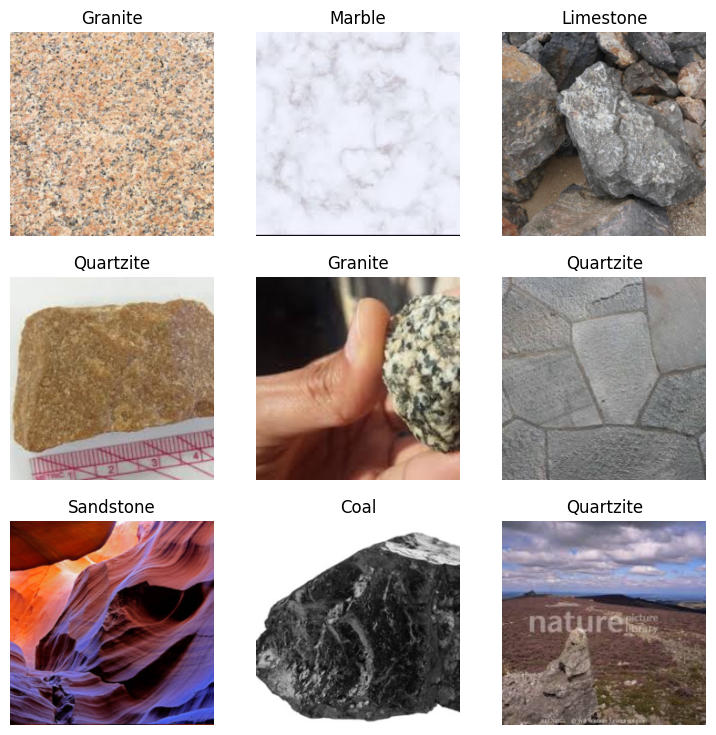

In [ ]:
#| echo:false

dls.show_batch()

## Data Augmentation using FastAI

### MixUp

In [ ]:
#|echo: false

mixup = MixUp(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())

### CutMix

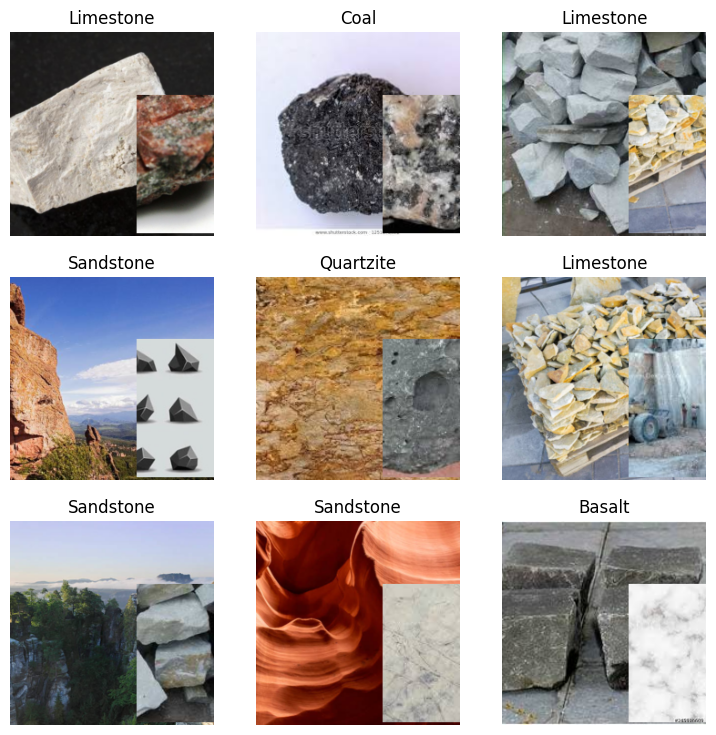

In [ ]:
#|echo: false

cutmix = CutMix(1.)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=cutmix) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_train')
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(cutmix.x,cutmix.y), ctxs=axs.flatten())